In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.optimize as so
import scipy.integrate as si
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

<h1>Forward Problem</h1>

In [2]:
###############################################################
# set computational parameters
###############################################################

# size of spatial domain
L = 15.0

# number of real space grid points (for plotting)
numx = 1025

# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)
# np.save(cwddir/'xvec', xvec)
# print('xvec saved.')

# number of Fourier basis functions
numfour = 32

# number of Toeplitz elements in the Fourier representation
numtoepelms = 2 * numfour + 1

# set time-step size
dt = 1e-2  # 1e-2

# set number of time steps
# trajectory length = numts + 1
numts = 20  # 20

print('Computational parameters set.')

cmpenv = {'L': L, 'numx': numx, 'numfour': numfour, 'dt': dt, 'numts': numts}
print(cmpenv)



Computational parameters set.
{'L': 15.0, 'numx': 1025, 'numfour': 32, 'dt': 0.01, 'numts': 20}


In [3]:
###############################################################
# utility variables
###############################################################

# vector of Fourier mode indices
# fournvec = -numfour,...,0,...,numfour
fournvec = np.arange(-numfour, numfour + 1)

# matrix for converting Fourier representation to real space
# used like realspacevec = fourspacevec @ fourtox
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)



In [4]:
###############################################################
# potential
###############################################################

vselect = 0

# define true potential (for generating training data)
if vselect == 0:
    def v(z):
        # harmonic oscillator potential (should be exact for Chebyshev)
        return 0.5 * z**2
elif vselect == 1:
    def v(z):
        # symmetric double well potential
        return 2.5e-3 * (z ** 2 - 25) ** 2
elif vselect == 2:
    def v(z):
        # asymmetric double well potential
        c0 = 4.35
        c1 = 9.40e-1
        c2 = -3.56e-1
        c3 = -4.66e-2
        c4 = 1.46e-2
        c5 = 6.76e-4
        c6 = -1.26e-4
        c7 = -5.43e-6
        c8 = 4.12e-7
        c9 = 1.65e-8
        x = z + 0.8
        return 0.5 * (c0 + c1 * x + c2 * x ** 2 + c3 * x ** 3 + c4 * x ** 4 + c5 * x ** 5 + c6 * x ** 6 + c7 * x ** 7 + c8 * x ** 8 + c9 * x ** 9)
elif vselect == 3:
    def v(z):
        # non-polynomial potentials
        return np.sin(0.4 * z - 1)
elif vselect == 4:
    def v(z):
        # non-polynomial potentials
        return np.sin((0.5 * z) ** 2)
elif vselect == 5:
    def v(z):
        # non-polynomial potentials
        return 15 * (-np.cos(z) + np.sin((0.5 * z) ** 2 - 0.2 * z))
elif vselect == 6:
    def v(z):
        # soft coulomb potential
        return -1 / np.sqrt(z ** 2 + 0.25)
else:
    print('Selection of potential not recognized.')

# true potential on real space grid (for plotting)
vxvec = v(xvec)

# compute the potential operator matrix, vmat
vtoeptrue = []
for thisfourn in range(numtoepelms):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    vtoeptrue.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

vtoeptrue = jnp.array(vtoeptrue)

vmattrue = sl.toeplitz(r=vtoeptrue, c=np.conj(vtoeptrue))

In [5]:
###############################################################
# initial state
###############################################################

def psi0_0(x):
    return 10 * np.exp(-((x + 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return 10 * np.exp(-((x + 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_1(x):
    return np.exp(-((x - 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_2(x):
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25
    return np.exp(-((x - 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_3(x):
    # a weird non-symmetric wavefunction
    # return np.abs(np.sin((0.15*x - 0.5)**2))
    return np.exp(-((x + 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x + 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_4(x):
    return np.exp(-((x - 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 11)**2) * (2.0 / np.pi)**0.25

def psi0_5(x):
    return np.exp(-((x + 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 11)**2) * (2.0 / np.pi)**0.25


# function for normalizing initial wave functions
# and transforming them to the Fourier representation
def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    norm_psi0fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    a0raw = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        a0raw.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(a0raw[1:])), a0raw])
    a0 = jnp.array(a0)
    normpsi0x = norm_psi0fn(xvec)

    return a0, normpsi0x


# generate initial state vector
# pick initial un-normalized wave functions
psi0fnvec = [psi0_0, psi0_1, psi0_2, psi0_3]  # [psi0_0, psi0_1, psi0_2, psi0_3, psi0_4, psi0_5]

# run mka0
a0vec = []
normpsi0xvec = []
normpsi0recxvec = []
for thispsi0fn in psi0fnvec:
    tempa0, tempnormpsi0x = mka0(thispsi0fn)
    a0vec.append(tempa0)
    normpsi0xvec.append(tempnormpsi0x)
    normpsi0recxvec.append(tempa0 @ fourtox)

In [6]:
###############################################################
# forward propagation using true potential
###############################################################

# make kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))

# Hamiltonian operator with true potential
# in the Fourier representation
hmattrue = kmat + vmattrue

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = jnl.eigh(hmattrue)

# compute propagator matrix
propatrue = stttrue @ jnp.diag(jnp.exp(-1j * spctrue * dt)) @ stttrue.conj().T

# propagate system starting from initial "a" state
# using the Hamiltonian constructed from the true potential
# (used for generating training data)
amattruevec = []
for thisa0 in a0vec:
    tempamat = [thisa0.copy()]
    for i in range(numts):
        tempamat.append(propatrue @ tempamat[-1])

    amattruevec.append(tempamat)

amattruevec = jnp.array(amattruevec)

print('Done generating training data (i.e., the forward problem).')

Done generating training data (i.e., the forward problem).


<h1>Inverse Problem</h1>

In [7]:
###############################################################
# make amp squared training data from amattruevec,
# i.e., |\psi(t)|^2 in the Fourier representation
###############################################################

print('Starting inverse problem.')

betamatvec = []
for thisamattrue in amattruevec:
    tempbetamat = []
    for thisavectrue in thisamattrue:
        tempbetamat.append(jnp.correlate(thisavectrue, thisavectrue, 'same'))

    betamatvec.append(jnp.array(tempbetamat))

betamatvec = jnp.array(betamatvec) / jnp.sqrt(2 * L)

print('Training data generated.')



Starting inverse problem.
Training data generated.


In [8]:
###############################################################
# Toeplitz indexing matrix
###############################################################

# Toeplitz indexing matrix,
# used for constructing Toeplitz matrix
# Indexed vector setup like:
# jnp.concatenate([jnp.flipud(row.conj()), row[1:]])
aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
toepindxmat = np.array(aa + bb)
# print(toepindxmat.shape)



In [9]:
###############################################################
# initialize theta
###############################################################

# initialize theta with random coefficients close to zero
seed = 1234  # set to None for random initialization
# thetarnd = 0.001 * np.random.default_rng(seed).normal(size=thetatrue.shape)
thetarnd = 0.001 * np.random.default_rng(seed).normal(size=numtoepelms * 2 - 1)
thetarnd = jnp.array(thetarnd)



In [10]:
###############################################################
# define objective function
###############################################################

# define objective function
def ampsquaredobjective(theta):
    ##########################################################
    # theta is a vector containing the concatenation
    # of the real and imaginary parts of vmat
    # its size should be 2 * numtoepelms - 1 = 4 * numfour + 1
    ##########################################################

    # to use theta we need to first recombine the real
    # and imaginary parts into a complex valued vector
    vtoephatR = theta[:numtoepelms]
    vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    vtoephat = vtoephatR + 1j * vtoephatI

    # construct vmathat from complex toeplitz vector
    vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # **************************************************
    # the code enclosed by ' # ****' is the
    # same regardless of the model use
    # **************************************************
    # Construct Hamiltonian matrix
    hmathat = kmat + vmathat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hmathat)

    # compute the forward propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T

    # forward propagation loop
    rtnobj = 0.0
    # for r in range(len(a0vec)):
    for r in range(betamatvec.shape[0]):
        # thisahat = a0vec[r].copy()
        thisahat = amattruevec[r, 0].copy()
        thisbetahatmat = [jnp.correlate(thisahat, thisahat, 'same') / jnp.sqrt(2 * L)]

        # propagate system starting from initial "a" state
        # for _ in range(numts):
        for _ in range(betamatvec.shape[1] - 1):
            # propagate the system one time-step
            thisahat = propahat @ thisahat
            # calculate the amp^2
            thisbetahatmat.append(jnp.correlate(thisahat, thisahat, 'same') / jnp.sqrt(2 * L))

        # compute objective functions
        tempresid = jnp.array(thisbetahatmat) - betamatvec[r]
        thisobj = 0.5 * jnp.sum(jnp.abs(tempresid)**2)
        rtnobj += thisobj
    # **************************************************

    return rtnobj

# jit ampsquaredobjective
jitampsquaredobjective = jax.jit(ampsquaredobjective)
# precomplie and test jitampsquaredobjective
print(jitampsquaredobjective(thetarnd))



0.0027649667237180185


In [11]:
###############################################################
# adjoint method for computing gradient
###############################################################

# function for generating M and P matrix (used in adjoint method)
def mk_M_and_P(avec):
    halflen = len(avec) // 2
    padavec = jnp.concatenate((jnp.zeros(halflen), jnp.array(avec), jnp.zeros(halflen)))

    rawmat = []
    for j in range(2 * halflen + 1):
        rawmat.append(padavec[2 * halflen - j:4 * halflen + 1 - j])

    Mmat = jnp.conjugate(jnp.array(rawmat))
    Pmat = jnp.flipud(jnp.array(rawmat))

    return Mmat, Pmat

# jit mk_M_and_P
jit_mk_M_and_P = jax.jit(mk_M_and_P)

# function for computing gradients using adjoint method
def adjgrads(theta):
    # to use theta we need to first recombine the real
    # and imaginary parts into a vector of complex values
    vtoephatR = theta[:numtoepelms]
    vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    vtoephat = vtoephatR + 1j * vtoephatI
    # print('Shape vtoephat:', vtoephat.shape)

    # construct vmathat from complex toeplitz vector
    vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # **************************************************
    # the code enclosed by ' # ****' is the same
    # regardless of the model you use
    # **************************************************
    # Construct Hamiltonian matrix
    hmathat = kmat + vmathat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hmathat)

    # compute the forward propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T
    proplam = jnp.transpose(jnp.conjugate(propahat))

    # forward propagation
    ahatmatvec = []
    lammatvec = []
    # for r in range(len(a0vec)):
    for r in range(betamatvec.shape[0]):
        # propagate system starting from initial "a" state
        # thisahatmat = [a0vec[r].copy()]
        thisahatmat = [amattruevec[r, 0].copy()]
        thisbetahatmat = [jnp.correlate(thisahatmat[0], thisahatmat[0], 'same') / jnp.sqrt(2 * L)]
        # thisrhomat = [jnp.correlate(thisahatmat[0], thisahatmat[0], 'same') / jnp.sqrt(2 * L)]
        thispartlammat = [jnp.zeros(numtoepelms, dtype=complex)]

        # propagate system starting from thisa0vec state
        # for i in range(numts):
        for i in range(betamatvec.shape[1] - 1):
            # propagate the system one time-step and store the result
            thisahatmat.append(propahat @ thisahatmat[-1])

            # calculate the amp^2
            thisbetahatmat.append(jnp.correlate(thisahatmat[-1], thisahatmat[-1], 'same') / jnp.sqrt(2 * L))
            # thisrhomat.append(jnp.correlate(thisahatmat[-1], thisahatmat[-1], 'same') / jnp.sqrt(2 * L))

            # compute \rho^r - \beta^r
            # compute \betahat^r - \beta^r
            thiserr = thisbetahatmat[-1] - betamatvec[r, i+1]
            # thiserr = thisrhomat[-1] - betamatvec[r, i+1]

            # compute M and P matrix for lambda mat
            thisMmat, thisPmat = jit_mk_M_and_P(thisahatmat[-1])

            # compute part of lambda mat
            # ( 1 / \sqrt{2 L} ) * [ ( M^r )^\dagger * ( \rho^r - \beta^r )
            # + \overline{( P^r )^\dagger * ( \rho^r - \beta^r )} ]
            thispartlammat.append((thisMmat.conj().T @ thiserr + (thisPmat.conj().T @ thiserr).conj()) / jnp.sqrt(2 * L))

        # store compute ahatmat
        ahatmatvec.append(jnp.array(thisahatmat))

        # build lammat backwards then flip at the end
        thislammat = [thispartlammat[-1]]
        for i in range(2, numts + 2):
            thislammat.append(thispartlammat[-i] + proplam @ thislammat[-1])

        lammatvec.append(jnp.flipud(jnp.array(thislammat)))

    # make lists into JAX array object
    ahatmatvec = jnp.array(ahatmatvec)
    lammatvec = jnp.array(lammatvec)


    ##########################################################
    # Compute the gradients
    # The remainder of this function is for computing the
    # directional derivative of the matrix exponential.
    ##########################################################

    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    myeye = jnp.eye(numtoepelms)
    wsR = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
    ctrmatsR = wsR[toepindxmat]
    prederivamatR = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, ctrmatsR,stthat)
    derivamatR = prederivamatR * jnp.expand_dims(mask,2)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil',stthat, derivamatR, stthat.conj().T)

    wsI = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:,1:]])
    wsI = wsI[1:,:]
    wsI = wsI.T
    ctrmatsI = wsI[toepindxmat]
    prederivamatI = jnp.einsum('ij,jkm,kl->ilm',stthat.conj().T, ctrmatsI, stthat)
    derivamatI = prederivamatI * jnp.expand_dims(mask, 2)
    alldmatimag = -1j * dt * jnp.einsum('ij,jkm,kl->mil',stthat, derivamatI, stthat.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])

    # compute all entries of the gradient at once
    gradients = jnp.real(jnp.einsum('bij,ajk,bik->a', jnp.conj(lammatvec[:, 1:]), alldmat, ahatmatvec[:, :-1]))

    return gradients


# jit adjgrads
jitadjgrads = jax.jit(adjgrads)
# precompile jitadjgrads
print(nl.norm(jitadjgrads(thetarnd)))



0.0036963383771006285


In [16]:
###############################################################
# adjoint method for computing Hessian
###############################################################

def purejaxhess(dvec, alldmat):
    jd = jnp.array(-1j*dt*dvec)
    jed = jnp.exp(jd)
    jedi = jnp.expand_dims(jed,1)
    jedj = jnp.expand_dims(jed,0)
    jdi = jnp.expand_dims(jd,1)
    jdj = jnp.expand_dims(jd,0)
    mask = jnp.expand_dims(jnp.eye(numtoepelms), [0,1])
    out = jnp.expand_dims(alldmat,1)*jnp.expand_dims(alldmat,0)*mask*jedi
    jtmp = -jedi + jdi*jedi - jdj*jedi + jedj
    jtmp *= ((jdi!=jdj)*(jdi-jdj)**(-2))
    jtmp2 = jnp.expand_dims(alldmat,1).transpose([0,1,3,2]) * jnp.expand_dims(alldmat,0)
    jtmp2 += jnp.expand_dims(alldmat,1) * jnp.expand_dims(alldmat,0).transpose([0,1,3,2])
    jtmp2 *= jtmp
    out += jnp.expand_dims(jnp.sum(jtmp2,axis=3),2) * mask

    unmask = 1-jnp.eye(numtoepelms)
    # bmat[thread_number,i,i]
    # column vector with diagonal * amat .... bmat[thread_number,i,i]*amat[thread_number,i,k]
    # bmat * row vector with diagonal ....... bmat[thread_number,i,k]*amat[thread_number,k,k]
    bmatii = jnp.expand_dims(jnp.diagonal(alldmat,axis1=1,axis2=2),[0,3]) # * mask
    bmatkk = jnp.expand_dims(jnp.diagonal(alldmat,axis1=1,axis2=2),[0,2]) # * mask
    amatik = jnp.expand_dims(alldmat,1)
    bmatik = jnp.expand_dims(alldmat,0)
    amatkk = jnp.expand_dims(jnp.diagonal(alldmat,axis1=1,axis2=2),[1,2]) #* mask
    amatii = jnp.expand_dims(jnp.diagonal(alldmat,axis1=1,axis2=2),[1,3]) #* mask
    jdk = jnp.expand_dims(jd,0)
    jedk = jnp.expand_dims(jed,0)
    jdimk = jdi-jdk
    jdimkm1 = (jdi!=jdk)*(jdimk**(-1))
    jtmp3 = -jedi + jdimk*jedi + jedk
    jtmp3 *= (jdimkm1**2)
    jtmp4 = jtmp3 * (bmatii*amatik + amatii*bmatik)
    jtmp5 = -(-jedi + jedk + jdimk*jedk)
    jtmp5 *= (jdimkm1**2)
    jtmp6 = jtmp5 * (bmatik*amatkk + amatik*bmatkk)
    out2 = jtmp4*unmask
    out2 += jtmp6*unmask

    term1 = jnp.einsum('bij,ij,jk,ajk->abik',alldmat,jdimkm1,unmask,alldmat)
    term1 += jnp.einsum('aij,ij,jk,bjk->abik',alldmat,jdimkm1,unmask,alldmat)
    term1 *= (-jedi*jdimkm1)

    term2 = jnp.einsum('bij,j,ij,ajk,jk->abik',alldmat,jed,jdimkm1,alldmat,jdimkm1)
    term2 += jnp.einsum('aij,j,ij,bjk,jk->abik',alldmat,jed,jdimkm1,alldmat,jdimkm1)

    term3 = jnp.einsum('bij,ij,jk,ajk->abik',alldmat,unmask,jdimkm1,alldmat)
    term3 += jnp.einsum('aij,ij,jk,bjk->abik',alldmat,unmask,jdimkm1,alldmat)
    term3 *= (-jedk*jdimkm1)

    bigunmask = jnp.expand_dims(unmask,[0,1])
    out3 = -bigunmask*(term1 + term2 + term3)

    return out+out2+out3


def adjhess(theta):
    ##########################################################
    # theta is the set of parameters being trained
    # Here, theta is the concatenation of the real and imaginary
    # of the Fourier representation of the potential matrix, vmat.
    # To construct the potential matrix from theta:
    #   1. Recombine the real and imaginary parts into
    #     complex values
    #   2. Construct a Toeplitz matrix from the set of complex
    #     values using toepindxmat
    ##########################################################
    vtoephatR = theta[:numtoepelms]
    vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    vtoephat = vtoephatR + 1j * vtoephatI

    # construct vmathat from complex toeplitz vector
    vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]


    # **************************************************
    # the code enclosed by ' # ****' is the same
    # regardless of the model used
    # - this code computes the forward propagation ahatmatvec
    #   and the adjoint problem, lammatvec
    # **************************************************
    # Construct Hamiltonian matrix
    hmathat = kmat + vmathat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hmathat)

    # compute the forward propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T

    # compute the backwards propagator matrix
    proplam = jnp.transpose(jnp.conjugate(propahat))


    ##########################################################
    # construct ahatmat and lammat
    ##########################################################
    ahatmatvec = []
    lammatvec = []
    # for r in range(len(a0vec)):
    for r in range(betamatvec.shape[0]):
        # propagate system starting from initial "a" state
        # thisahatmat = [a0vec[r].copy()]
        thisahatmat = [amattruevec[r, 0].copy()]
        thisbetahatmat = [jnp.correlate(thisahatmat[0], thisahatmat[0], 'same') / jnp.sqrt(2 * L)]
        # thisrhomat = [jnp.correlate(thisahatmat[0], thisahatmat[0], 'same') / jnp.sqrt(2 * L)]
        thispartlammat = [jnp.zeros(numtoepelms, dtype=complex)]

        # propagate system starting from thisa0vec state
        # for i in range(numts):
        for i in range(betamatvec.shape[1] - 1):
            # propagate the system one time-step and store the result
            thisahatmat.append(propahat @ thisahatmat[-1])

            # calculate the amp^2
            thisbetahatmat.append(jnp.correlate(thisahatmat[-1], thisahatmat[-1], 'same') / jnp.sqrt(2 * L))
            # thisrhomat.append(jnp.correlate(thisahatmat[-1], thisahatmat[-1], 'same') / jnp.sqrt(2 * L))

            # compute \rho^r - \beta^r
            # compute \betahat^r - \beta^r
            thiserr = thisbetahatmat[-1] - betamatvec[r, i+1]
            # thiserr = thisrhomat[-1] - betamatvec[r, i+1]

            # compute M and P matrix for lambda mat
            thisMmat, thisPmat = jit_mk_M_and_P(thisahatmat[-1])

            # compute part of lambda mat
            # ( 1 / \sqrt{2 L} ) * [ ( M^r )^\dagger * ( \rho^r - \beta^r )
            # + \overline{( P^r )^\dagger * ( \rho^r - \beta^r )} ]
            thispartlammat.append((thisMmat.conj().T @ thiserr + (thisPmat.conj().T @ thiserr).conj()) / jnp.sqrt(2 * L))

        # store compute ahatmat
        ahatmatvec.append(jnp.array(thisahatmat))

        # build lammat backwards then flip at the end
        thislammat = [thispartlammat[-1]]
        for i in range(2, numts + 2):
            thislammat.append(thispartlammat[-i] + proplam @ thislammat[-1])

        lammatvec.append(jnp.flipud(jnp.array(thislammat)))

    # make lists into JAX array object
    ahatmatvec = jnp.array(ahatmatvec)
    lammatvec = jnp.array(lammatvec)
    # **************************************************

    ##########################################################
    # The remainder of this function is for computing the
    # directional derivative of the matrix exponential.
    ##########################################################

    # **************************************************
    # the code enclosed by ' # ****' is the same
    # regardless of the model used
    # - this code computes the gradient of the a state
    #   WRT the learning parameters, \theta
    # **************************************************
    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    # **************************************************

    myeye = jnp.eye(numtoepelms)
    wsR = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
    ctrmatsR = wsR[toepindxmat]
    prederivamatR = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, ctrmatsR,stthat)
    derivamatR = prederivamatR * jnp.expand_dims(mask,2)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil',stthat, derivamatR, stthat.conj().T)

    wsI = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:,1:]])
    wsI = wsI[1:,:]
    wsI = wsI.T
    ctrmatsI = wsI[toepindxmat]
    prederivamatI = jnp.einsum('ij,jkm,kl->ilm',stthat.conj().T, ctrmatsI, stthat)
    derivamatI = prederivamatI * jnp.expand_dims(mask, 2)
    alldmatimag = -1j * dt * jnp.einsum('ij,jkm,kl->mil',stthat, derivamatI, stthat.conj().T)

    prederivamats = jnp.concatenate([prederivamatR, prederivamatI], axis=2)

    # **************************************************
    alldmat = jnp.vstack([alldmatreal, alldmatimag])
    # **************************************************


    # **************************************************
    # the code enclosed by ' # ****' is the same
    # regardless of the model used
    # **************************************************
    ############################################
    # Compute the Hessian
    ############################################

    # because we have a collection of trajectories for each
    # potential, we need to compute the Hessian for each
    # trajectory separate and then sum the result?
    hessvec = []
    for r in range(betamatvec.shape[0]):
        # construct {nabla_{theta} a_j}_{j=0}^N
        # using the step equation:
        # nabla_theta a_{j+1}
        #   = nabla_a phi_h nabla_theta a_{j}
        #     + nabla_theta phi_h
        # - because a_0 is known, nabla_theta a_j = 0
        # - a is a vector of length numtoepelms, with the
        #   Fourier model, theta is a vector of 2 * numtoepelms - 1
        #   so one element of gradamat is a matrix of dimensions
        #   numtoepelms x 2 * numtoepelms - 1
        gradamat = [jnp.zeros((numtoepelms, 2 * numtoepelms - 1))]
        for j in range(numts):
            # nabla_a \phi_h = exp(-i H \Delta t) a
            #                = proplam @ nabla_theta a_j
            # nabla_theta a_j = previously computed element
            #                 = gradamat[-1]
            t1 = proplam @ gradamat[-1]
            # nabla_theta \phi_h = Q @ a = U M U^\dagger @ a_j
            #                    = alldmat @ a_j
            t2 = jnp.transpose(alldmat @ ahatmatvec[r, j,:])
            gradamat.append(t1 + t2)

        # make python list into a JAX object
        gradamat = jnp.array(gradamat)


        ############################################
        # compute nabla_theta lambda, i.e., solve the
        # second order adjoint problem
        ############################################

        # Initialize gradlamb, last term known to be
        # nabla_theta lambda_N = nabla_theta a_N
        #                      = gradamat[-1]
        gradlamb = [gradamat[-1]]

        # build nabla_theta lambda_j backwards
        # we want nabla_theta lambda^\dagger but
        # we are constructing nabla_theta lambda
        for j in range(numts-1,-1,-1):
            # term1 = \nabla_a \phi^\dagger \nabla_\theta \lambda_{j+1}
            term1 = proplam @ gradlamb[-1]
            # term2 = \nabla_{\theta a} \phi^\dagger \lambda_{j+1}
            #       = Q^\dagger \lambda_{j+1}
            #       = alldmat^\dagger @ \lambda_{j+1}
            alldmatH = np.transpose(alldmat.conj(),axes=(2,1,0))
            term2 = jnp.einsum('ijk,j->ik', alldmatH, lammatvec[r, j+1])
            gradlamb.append(gradamat[j] + term1 + term2)

        gradlamb = jnp.flipud( jnp.stack(gradlamb) )

        hesspt1 = jnp.real(jnp.einsum('ijl,ajk,ik->al', jnp.conj(gradlamb[1:,:,:]), alldmat, ahatmatvec[r,:-1,:]))
        hesspt2 = jnp.real(jnp.einsum('ij,ajk,ikl->al', jnp.conj(lammatvec[r, 1:,:]), alldmat, gradamat[:-1,:,:]))
        res = purejaxhess(spchat, -1j * dt * jnp.transpose(prederivamats,[2,0,1]))
        hesspt3 = jnp.real(jnp.einsum('ci,ij,abjk,lk,cl->ab',jnp.conj(lammatvec[r, 1:,:]), stthat, res, jnp.conj(stthat), ahatmatvec[r, :-1,:], optimize=True))

        hessvec.append(hesspt1 + hesspt2 + hesspt3)

    hessvec = jnp.array(hessvec)

    return jnp.sum(hessvec, axis=0)


# jit adjhess
jitadjhess = jax.jit(adjhess)
# precompile jitadjhess
print(nl.norm(jitadjhess(thetarnd)))

14.376814958762596


In [17]:
###############################################################
# learn theta
###############################################################

# start optimization (i.e., learning theta)
rsltadjthetarnd = so.minimize(fun=jitampsquaredobjective,
                              x0=thetarnd,
                              jac=jitadjgrads,
                              hess=jitadjhess,
                              method='trust-krylov',
                              tol=1e-12,
                              options={'maxiter': 100, 'disp': True, 'gtol': 1e-15}).x

 iter inewton type    objective     âgââ_Mâ»Â¹      leftmost         Î»             Î³             Î´             Î±             Î²       
     0     0  cg_i -4.619610e-06  3.788570e-03  0.000000e+00  0.000000e+00  3.696338e-03  1.478796e+00  6.762260e-01  1.050527e+00

 TR Solving trust region problem, radius 1.000000e+00; starting on first irreducible block
 TR Coldstart. Seeking suitable initial Î»â, starting with 0
 TR  Î»â = 0 unsuitable â¥ get leftmost ev of first block!
 TR  
 TR  perturb Î»â by safeguarded bisection to find suitable initial value
 TR Starting Newton iteration for Î»â with initial choice 2.250531e-02
 TR  iter        Î»            dÎ»       âhâ(Î»)â-radius
 TR      1  2.513146e-02  2.626146e-03  3.674891e-07
 TR      2  2.513146e-02  9.650807e-10 -1.609823e-14


 iter inewton type    objective     Î³áµ¢ââ|háµ¢|      leftmost         Î»             Î³             Î´             Î±             Î²       

     1     2  cg_b -1.387992e-02  

<h1>Results</h1>

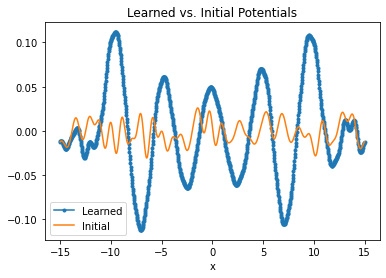

l2 error of learned potential:
1613.8472764878125
l-inf error of learned potential:
37.57500712242874


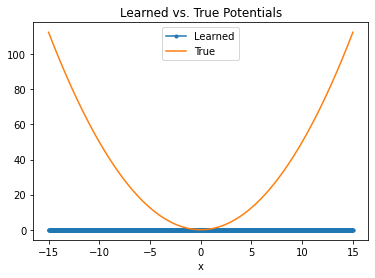

l2 error of shifted learned potential:
1614.993220165495
l-inf error of shifted learned potential:
37.6217574374893


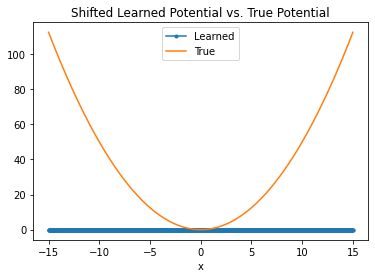

trim = 171
l2 error of shifted and trimmed learned potential:
585.6403159047208
l-inf error of shifted and trimmed learned potential:
16.73259188734569


In [18]:
###############################################################
# function for transforming theta to real space potential
###############################################################

def thetatoreal(theta):
    thetaR = theta[:numtoepelms]
    thetaI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    thetacomplex = thetaR + 1j * thetaI
    potentialfourier = np.sqrt(2 * L) * np.concatenate([np.conjugate(np.flipud(thetacomplex[1:(numfour + 1)])), thetacomplex[:(numfour + 1)]])
    potentialreal = potentialfourier @ fourtox
    return potentialreal

# transform randtheta theta (i.e., initvhatmat) to real space potential
vinitrec = thetatoreal(thetarnd)

# transform learned theta to real space potential
vlearnrec = thetatoreal(rsltadjthetarnd)


###############################################################
# transform learned theta (i.e., vhatmat) to real space potential
###############################################################

# learned potential vs initial potential
plt.plot(xvec, jnp.real(vlearnrec), '.-', label='Learned')
plt.plot(xvec, jnp.real(vinitrec), label='Initial')
plt.xlabel('x')
plt.title('Learned vs. Initial Potentials')
plt.legend()
plt.show()

# learned potential vs true potential
print('l2 error of learned potential:', nl.norm(jnp.real(vlearnrec) - vxvec), sep='\n')
print('l-inf error of learned potential:', np.mean(np.abs(jnp.real(vlearnrec) - vxvec)), sep='\n')
plt.plot(xvec, jnp.real(vlearnrec), '.-', label='Learned')
plt.plot(xvec, vxvec, label='True')
plt.xlabel('x')
plt.title('Learned vs. True Potentials')
plt.legend()
plt.show()

# shifted learned potential vs true potential
zeroindex = np.where(xvec == 0)[0][0]
# zeroindex = len(xvec) // 2
shift = vxvec[zeroindex] - jnp.real(vlearnrec)[zeroindex]
print('l2 error of shifted learned potential:', nl.norm(jnp.real(vlearnrec) + shift - vxvec), sep='\n')
print('l-inf error of shifted learned potential:', np.mean(np.abs(jnp.real(vlearnrec) + shift - vxvec)), sep='\n')
plt.plot(xvec, jnp.real(vlearnrec) + shift, '.-', label='Learned')
plt.plot(xvec, vxvec, label='True')
plt.xlabel('x')
plt.title('Shifted Learned Potential vs. True Potential')
plt.legend()
plt.show()

# Shifted and trimmed learned potential vs true potential
trim = np.where(xvec >= -10)[0][0]  # 125
print('trim =', trim)
print('l2 error of shifted and trimmed learned potential:', nl.norm(jnp.real(vlearnrec)[trim:-trim] + shift - vxvec[trim:-trim]), sep='\n')
print('l-inf error of shifted and trimmed learned potential:', np.mean(np.abs(jnp.real(vlearnrec)[trim:-trim] + shift - vxvec[trim:-trim])), sep='\n')